<a href="https://colab.research.google.com/github/johnGachihi/Machine-Learning/blob/master/CAT_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install seaborn

In [234]:
import pandas as pd
import numpy as np
from sklearn.datasets import california_housing
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet, LassoLars, Lars, OrthogonalMatchingPursuit

In [235]:
data = california_housing.fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.DataFrame(data.target, columns=["Price"])

## i. Data Preprocessing

### i. a. Filling missing values
We found that there were no NA values in the dataset.

In [236]:
total_missing_value = X.isna().values.sum()
print("Number of NaN values:", total_missing_value)

Number of NaN values: 0


### i. b. Encoding
Also, we found that there were no categorical features and, therefore, no reason for encoding.

In [237]:
categorical_data = X.select_dtypes(include=['object'])
print("Number of categorical features:", categorical_data.columns.size)

Number of categorical features: 0


### i. c. Feature Extraction

In [ ]:
X = PowerTransformer().fit_transform(X)
y = PowerTransformer().fit_transform(y)

pca = PCA(0.90)
pc_s = pca.fit_transform(X)

columns = [f"PC{c}" for c in range(1, pc_s.shape[1] + 1)]
columns.append("Price")
data = pd.DataFrame(np.append(pc_s, y, 1), columns=columns)



## ii. Data distribution examination

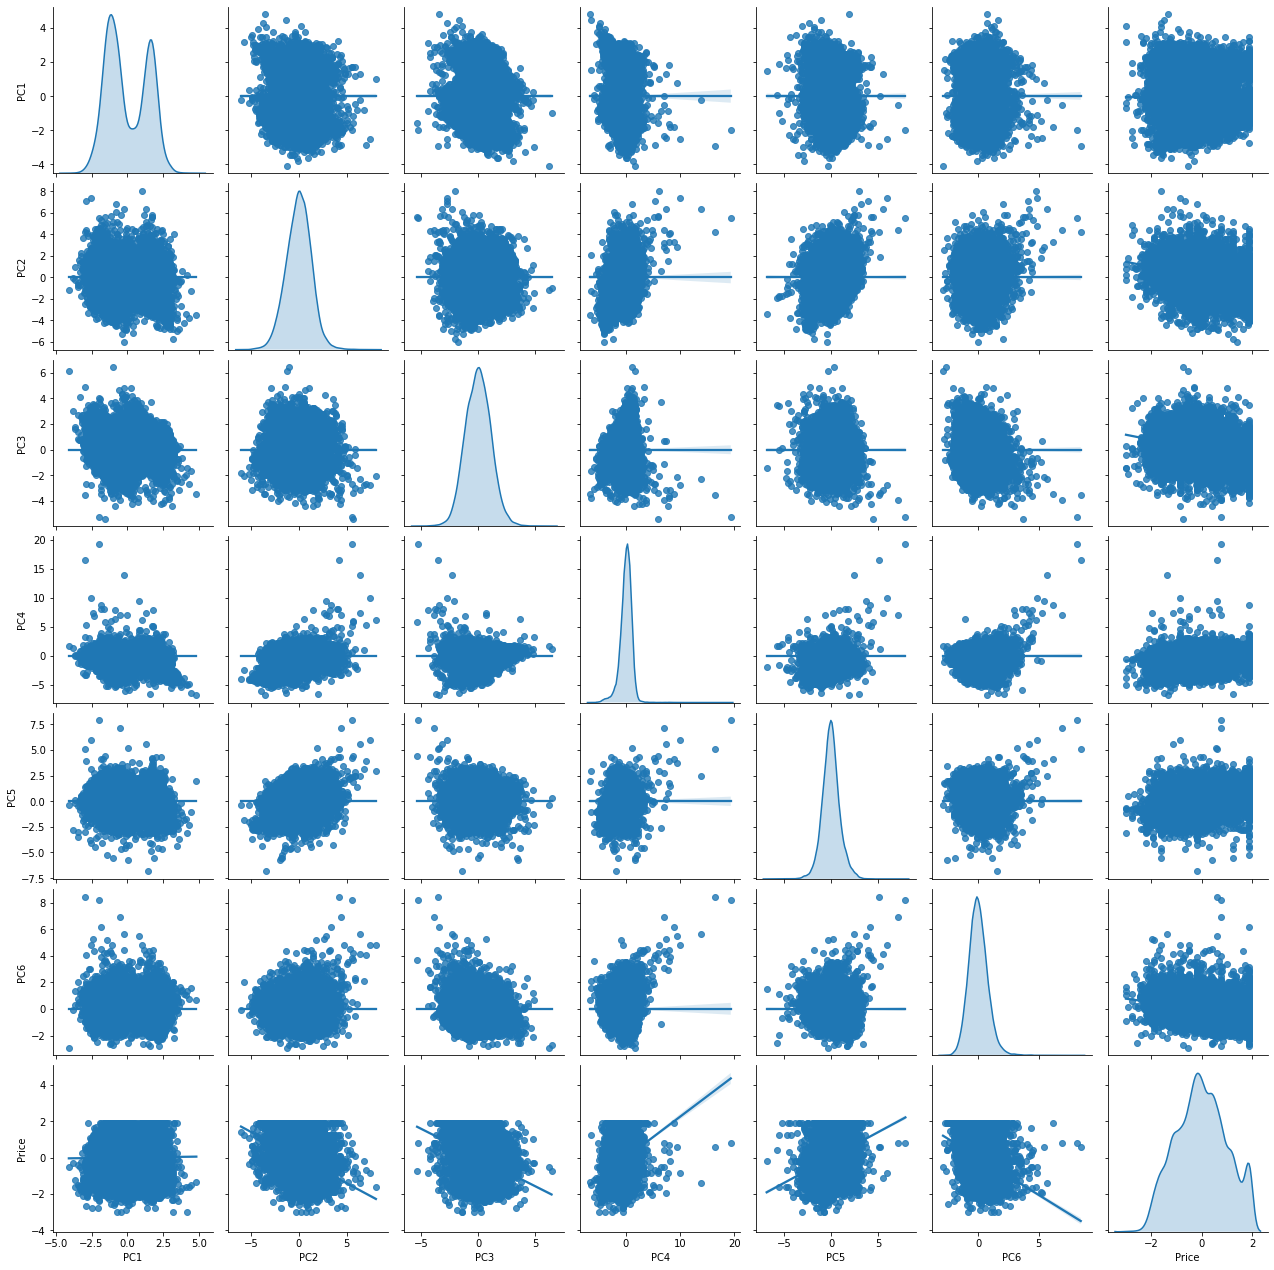

In [239]:
 sns.pairplot(data, kind="reg", diag_kind="kde")

 ___

Variables and function to be used for the next questions

In [240]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=101)

pca_train, pca_test, y_train, y_test = train_test_split(
    pc_s, y, test_size=0.3, random_state=101)

def fit_and_score(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  return model.score(X_test, y_test)

## iii. Model Selection
Before hyperparameter tuning and cross validation, we found that the best model for this problem are `LinearRegression()`, `Lars()` or `Ridge()`.

We also noticed that when we performed feature extraction on the data using PCA, the accuracy of the models became significantly lower than when using the data as it is. **We wonder why**.

In [241]:
models = {
    'LinearRegr': LinearRegression(),
    'Lasso':      Lasso(),
    'Ridge':      Ridge(),
    'ElasticNet': ElasticNet(),
    'LassoLars':  LassoLars(),
    'Lars':       Lars(),
    'OMP':        OrthogonalMatchingPursuit()
}

scores = {}
pca_scores = {}
for i in models:
  scores[i] = fit_and_score(models[i], X_train, y_train, X_test, y_test)
  pca_scores[i] = fit_and_score(models[i], pca_train, y_train, pca_test, y_test)

pd.DataFrame([scores, pca_scores], ["Without PCA", "With PCA"])

,LinearRegr,Lasso,Ridge,ElasticNet,LassoLars,Lars,OMP
Without PCA,0.672622,-0.000048,0.672619,0.146880,-0.000048,0.672622,0.464682
With PCA,0.490198,-0.000048,0.490201,-0.000048,-0.000048,0.490198,0.143127


## iv. Hyperparameter tuning
After hyperparameter tuning, the accuracy measures for `Lasso()`, `ElasticNet()` and `LassoLars()` increased significantly. 

In [242]:
# hyperparam grids for each model (for tuning)
lasso_param_grid = {
    'alpha': [0.001001, 0.0001, 0.00001],
    "tol": [0.001, 0.0001, 0.00001]
}
elasticNet_param_grid = {
    'alpha': np.linspace(0, .00001, 10)[1:],
    'l1_ratio': np.linspace(0, 1, 10)[1:-1]
}
larsoLars_param_grid = {
    'alpha': lasso_param_grid['alpha']
}
omp_param_grid = {
    'n_nonzero_coefs': range(1, 7),
    # 'tol': [1, 2, 3, 4, 5, 6]
}
ridge_param_grid = {'alpha': [1, 0.001, 0.0001]}

models = {
    'LinearRegr': (LinearRegression(), {}, 1),
    'Lasso':      (Lasso(), lasso_param_grid, 9),
    'Ridge':      (Ridge(), ridge_param_grid, 3),
    'ElasticNet': (ElasticNet(), elasticNet_param_grid, 10),
    'LassoLars':  (LassoLars(), larsoLars_param_grid, 3),
    'Lars':       (Lars(), {}, 1),
    'OMP':        (OrthogonalMatchingPursuit(), omp_param_grid, 6)
}

scores = {}
pca_scores = {}
for i in models:
  model, param_grid, n_iters = models[i]
  model = RandomizedSearchCV(model, param_grid, n_iter=n_iters)
  pca_scores[i] = fit_and_score(model, pca_train, y_train, pca_test, y_test)
  scores[i]     = fit_and_score(model, X_train, y_train, X_test, y_test)

pd.DataFrame([scores, pca_scores], ["Without PCA", "With PCA"])

,LinearRegr,Lasso,Ridge,ElasticNet,LassoLars,Lars,OMP
Without PCA,0.672622,0.672635,0.672619,0.672622,0.672726,0.672622,0.596270
With PCA,0.490198,0.490208,0.490201,0.490199,0.490298,0.490198,0.490198


## v. Cross validation
After performing cross validation we found that all the models had a slight increase in accuracy.

We used \\( K=5 \\) after finding that it yields the best results.

Increasing \\( K \\) above \\( 5 \\) caused the accuracy of the models to decrease. After a quick Google search we found that this is due to an increase in variance/overfitting since a large \\( K \\) means that too much of the data is used for training and too little for testing.

Also, we found that decreasing \\( K \\) below \\( 5 \\) also caused the accuracy of the models to decrease. This is probably due to an increase in bias/underfitting since the lesser the \\( K \\), the lesser the data used for training.

In [243]:
scores = {}
for i in models:
  model, param_grid, n_iters = models[i]
  model = RandomizedSearchCV(model, param_grid, n_iters)
  fold_scores = cross_val_score(model, X_train, y_train, cv=5)
  scores[i] = [fold_scores.mean()]

pd.DataFrame(scores)

,LinearRegr,Lasso,Ridge,ElasticNet,LassoLars,Lars,OMP
0,0.67885,0.678839,0.678851,0.67885,0.678814,0.67885,0.608025
